# CM500329: Car Reviews Assignment
#### Objectives
The objectives of this assignment are as follows:

***Part 1: Sentiment prediction using naive Bayes***
- Implement a naive Bayes classifier using 80% (1106) of the reviews as training data. The training data should be selected at random from the full dataset. 
- Test the classifier using the remaining 20% (276) of the reviews and report the classifier’s performance using a confusion matrix.

***Part 2: Creating an improved classifier***
- Identify and research a way to improve on the solution to part 1.
- Implement this improvement and compare the results to the initial naive Bayes classifier.

#### Contents
<a href='#part1'>1. Sentiment prediction using naive Bayes</a>  
<a href='#part1.1'>- 1.1 Import data</a>  
<a href='#part1.2'>- 1.2 Clean text data</a>   
<a href='#part1.3'>- 1.3 Split data into training and test sets</a>  
<a href='#part1.4'>- 1.4 Apply stemming to the data</a>  
<a href='#part1.5'>- 1.5 Transform the training and test data using a bag of words model</a>   
<a href='#part1.6'>- 1.6 Train a multinomial naive Bayes model and assess performance</a>  

<a href='#part2'>2. Creating an improved classifier</a>  
<a href='#part2.1'>- 2.1 Reassess performance of baseline model</a>  
<a href='#part2.2'>- 2.2 Improving baseline performance</a>  
<a href='#part2.3'>- 2.3 Document vectors</a>   
<a href='#part3'>3. Conclusions</a>  
<a href='#part4'>4. References</a>

#### Notes
- To keep the notebook as clean as possible I have saved user defined functions and classes in a separate file named car_reviews_utils.py. These functions are presented in the same order that they appear within the notebook.
- Throughout this notebook, summaries of key findings for each section are written in <font color=blue> **blue text** </font>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, pos_tag

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

pd.set_option('display.max_colwidth', 100)

file_name = 'car-reviews.csv'
test_size = 0.2

%run "car_reviews_utils.py"

## Part 1: Sentiment prediction using naive Bayes <a id='part1'></a>

In this section we will clean the data, build a Naive Bayes model to predict sentiment and evaluate performance.

#### contents  
<a href='#part1.1'>1.1 Import data</a>  
<a href='#part1.2'>1.2 Clean text data</a>   
<a href='#part1.3'>1.3 Split data into training and test sets</a>  
<a href='#part1.4'>1.4 Apply stemming to the data</a>  
<a href='#part1.5'>1.5 Transform the training and test data using a bag of words</a>   
<a href='#part1.6'>1.6 Train a Multinomial Naive Bayes Model and assess performance</a>  

### 1.1 Import data <a id='part1.1'></a>
Firstly, let's import our data using Pandas and do some high level checks

In [2]:
# Import data
car_reviews = pd.read_csv(file_name)
car_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  1382 non-null   object
 1   Review     1382 non-null   object
dtypes: object(2)
memory usage: 21.7+ KB


In [3]:
# Check the first few records of the data
car_reviews.head()

,Sentiment,Review
0,Neg,In 1992 we bought a new Taurus and we really loved it So in 1999 we decided to try a new Tauru...
1,Neg,The last business trip I drove to San Francisco I went to Hertz Rentals and got a 1999 Ford T...
2,Neg,My husband and I purchased a 1990 Ford F250 and had nothing but problems we have owned the veh...
3,Neg,I feel I have a thorough opinion of this truck compared to most who post evaluations of their v...
4,Neg,AS a mother of 3 all of whom are still in carseats the only logical thing to do was to trade ...


In [4]:
# Check sentiment counts
car_reviews['Sentiment'].value_counts()

Pos    691
Neg    691
Name: Sentiment, dtype: int64

In [5]:
# Replace the sentiment field with a binary flag
replace_dict = {'Neg':0, 'Pos':1}
car_reviews.replace({'Sentiment':replace_dict}, inplace=True)
car_reviews['Sentiment'].value_counts()

0    691
1    691
Name: Sentiment, dtype: int64

<font color=blue> **Summary**
- The data has 1,382 records
- We have converted sentiment to a binary variable, where a value of 1 represents a positive review. This is in preparation for the supervised machine learning algorithms that we will apply later on
- Sentiment is evenly balanced, we have 691 positive reviews and 691 negative reviews

### 1.2 Clean text data <a id='part1.2'></a>
As a next step, let's clean the review variable so that it's in good shape for creating a bag of words model. We can do this step on all the data at once, without having to worry about data leakage between training and test sets.

In [6]:
# Combine the nltk and scikit-learn stopword lists!
all_stop_words = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))

# Clean the data
car_reviews_clean = clean_text_data(car_reviews, 'Review', all_stop_words)
car_reviews_clean.head()

,Sentiment,Review
0,0,bought new taurus really loved decided try new taurus care style newer version bought like new c...
1,0,business trip drove san francisco went hertz rentals got ford taurus thinking looked comfortable...
2,0,husband purchased ford f problems owned vehicle approximately years spent half time shop problem...
3,0,feel thorough opinion truck compared post evaluations vehicles truck owned new currently k miles...
4,0,mother carseats logical thing trade sx minivan minivan handful vehicles room family requires add...


In [7]:
# Print original and cleaned review
idx = 0
print(f'Review {idx} before cleaning:')
display(car_reviews['Review'][idx])

print(f'Review {idx} after cleaning:')
display(car_reviews_clean['Review'][idx])

Review 0 before cleaning:


' In 1992 we bought a new Taurus and we really loved it  So in 1999 we decided to try a new Taurus  I did not care for the style of the newer version  but bought it anyway I do not like the new car half as much as i liked our other one  Thee dash is much to deep and takes up a lot of room  I do not find the seats as comfortable and the way the sides stick out further than the strip that should protect your card from denting It drives nice and has good pick up  But you can not see the hood at all from the driver seat and judging and parking is difficult  It has a very small gas tank I would not buy a Taurus if I had it to do over  I would rather have my 1992 back  I dont think the style is as nice as the the 1992  and it was a mistake to change the style  In less than a month we had a dead battery and a flat tire '

Review 0 after cleaning:


'bought new taurus really loved decided try new taurus care style newer version bought like new car half liked thee dash deep takes lot room seats comfortable way sides stick strip protect card denting drives nice good pick hood driver seat judging parking difficult small gas tank buy taurus dont think style nice mistake change style month dead battery flat tire'

<font color=blue> **Summary**
- Our data has been cleaned!   
    - non-alphabetical characters have been removed
    - stop words such as 'in', 'we' and 'a' which are unlikely to affect sentiment have been removed
    - uppercase characters have been converted to lowercase
    - leading/trailing and multiple spaces have been removed
</font>

### 1.3 Split data into training and test sets <a id='part1.3'></a>
Next we will split the data into a training set with 80% of the data and a set set with the remaining 20% of the data

In [8]:
# First, lets convert the DataFrame to lists for the x and y variables
car_reviews_list = car_reviews_clean.values.tolist()

x = [x[1] for x in car_reviews_list]
y = [x[0] for x in car_reviews_list]

In [9]:
# Use train_test_split to create training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=84, shuffle=True)

print(f'% of data to use for training {(1-test_size)*100}%')
print(f'training set observations: {len(x_train)}')
print(f'training set positive reviews: {sum(y_train)} \n')
print(f'% of data to use for testing {test_size*100}%')
print(f'test set observations: {len(x_test)}')
print(f'test set positive reviews: {sum(y_test)}')

% of data to use for training 80.0%
training set observations: 1105
training set positive reviews: 554 

% of data to use for testing 20.0%
test set observations: 277
test set positive reviews: 137


<font color=blue> **Summary**
 - The data has been split into a training set with 80% of the data and a test set with 20% of the data
</font>

### 1.4 Apply stemming to the data <a id='part1.4'></a>
In this section we will apply stemming to the data.

According to Wikipedia, 'stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form'.

Stemming reduces variations of a word to a common root form. For example 'walk', 'walked' and 'walking' would all be stemmed to 'walk'. Using stemming we group together similar words that have a shared root form, and presumably shared meanings. Stemming will help to reduce the number of dimensions in our bag of words model. 

In this assignment we will use the NLTK implementation of the English (Porter2) stemmer. This stemmer makes several improvements to the original Porter stemmer introduced by M.F. Porter in 1980, generally through modified treatment of various suffixes (Snowballstem, 2002).

Concrete examples of stemming will be given in the following cells.

**Note:** In part 2 of this assignment we will explore lemmatization as an alternative to stemming.

In [10]:
# How does stemming impact the size of our vocabulary?
x_train_stem = stem_docs(x_train)
x_test_stem = stem_docs(x_test)

# Create a CountVectorizer and extract the vocab
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
vectorizer_vocab = vectorizer.get_feature_names()

# Create a CountVectorizer with stemming and extract the vocab
vectorizer_stem = CountVectorizer()
vectorizer_stem.fit(x_train_stem)
vectorizer_stem_vocab = vectorizer_stem.get_feature_names()

print(f'vocabulary size before stemming: {len(vectorizer_vocab)}')
print(f'vocabulary size after stemming: {len(vectorizer_stem_vocab)}')

vocabulary size before stemming: 14328
vocabulary size after stemming: 9033


#### Analyse the impact of stemming on a few words in the dictionary

In [11]:
# Check a few examples before and after stemming
before_and_after_stemming('acceler', vectorizer_vocab, vectorizer_stem_vocab)
before_and_after_stemming('impress', vectorizer_vocab, vectorizer_stem_vocab)
before_and_after_stemming('transmis', vectorizer_vocab, vectorizer_stem_vocab)
before_and_after_stemming('qualit', vectorizer_vocab, vectorizer_stem_vocab)

Stemming example for words starting with "acceler"
Original vocabulary
['accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerations', 'accelerator']
Stemmed vocabulary
['acceler'] 

Stemming example for words starting with "impress"
Original vocabulary
['impress', 'impressed', 'impresses', 'impressing', 'impression', 'impressions', 'impressive', 'impressively']
Stemmed vocabulary
['impress'] 

Stemming example for words starting with "transmis"
Original vocabulary
['transmissiion', 'transmission', 'transmissions']
Stemmed vocabulary
['transmiss', 'transmissiion'] 

Stemming example for words starting with "qualit"
Original vocabulary
['qualities', 'quality']
Stemmed vocabulary
['qualiti'] 



<font color=blue> **Summary**
- Words like 'accelerate', 'accelerated' and 'accelerates' are stemmed to the common root of 'accel'
- Applying stemming reduces the number of words in our vocabulary from **14,328** to **9,033**
</font>

### 1.5 Transform the training and test data using a bag of words model <a id='part1.5'></a>

We will now transform the documents into numerical feature vectors using a bag of words model.

#### Bag of words model
Bag of words models are one of the most common ways of converting text data into numerical features. A separate feature is output for every unique word in of the all documents, and the value of each feature for a given document represents the number of times that the word appears in within that document (Albon, 2018).

We will use the Scikit-Learn CountVectorizer class to create our bag of words model.

**Note:** The count vectors are fit using only the documents from our training data, so as to prevent any data leakage arising from 'seeing' words from the test set.

In [12]:
# Transform the review data using the count vectorizer
x_train_vec = vectorizer_stem.transform(x_train_stem).toarray()
x_test_vec = vectorizer_stem.transform(x_test_stem).toarray()

print(f'training matrix shape {x_train_vec.shape}')
print(f'test matrix shape {x_test_vec.shape}')

training matrix shape (1105, 9033)
test matrix shape (277, 9033)


#### Checking word fequencies

Let's have a look at the top 10 words by frequency

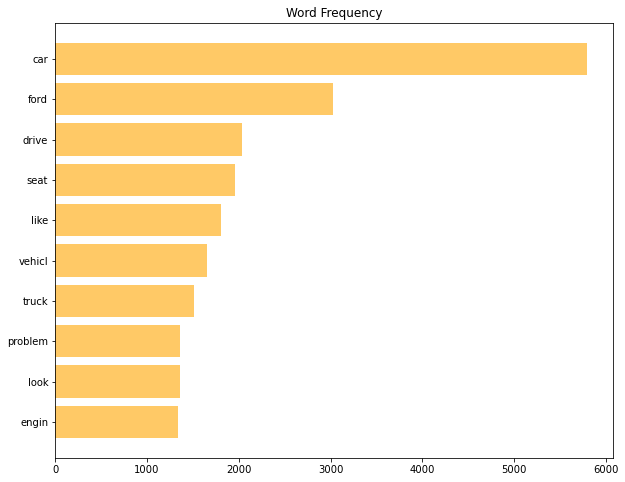

In [13]:
# Plot word frequencies
plot_word_freq(x_train_vec, vectorizer_stem.get_feature_names(), n_words=10)

From the frequency plot we see that 'car' is the most common word, appearing almost 6,000 times across documents in the training set. 'ford' is the second most common word, appearing almost 3,000 times. The fact that 'ford' appears so often is quite interesting, especially given the absence of other card brands amongst frequent words. Perhaps our review data is exclusively for Ford vehicles.

#### Checking the vectors

Observing the first 5 vectors from the training data we can see that the data appears to be sparsely populated, there are lots of zeros ...

In [14]:
x_train_vec[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

We can check which indices in the vector are non-zero using numpy's nonzero function. Let's check the first vector:

In [15]:
np.nonzero(x_train_vec[0])

(array([  30,   83,   93,  135,  146,  149,  167,  212,  213,  239,  309,
         321,  363,  381,  495,  499,  525,  565,  621,  666,  685,  689,
         717,  800,  833,  839,  863,  868,  913,  953,  968, 1008, 1021,
        1053, 1091, 1103, 1115, 1168, 1246, 1247, 1272, 1347, 1362, 1397,
        1417, 1442, 1460, 1471, 1479, 1499, 1530, 1620, 1634, 1669, 1670,
        1704, 1777, 1801, 1838, 1848, 1861, 1870, 1887, 1907, 1910, 1936,
        1942, 1946, 2004, 2116, 2242, 2308, 2357, 2379, 2389, 2399, 2402,
        2442, 2443, 2459, 2520, 2532, 2538, 2555, 2600, 2654, 2673, 2681,
        2686, 2691, 2720, 2727, 2741, 2749, 2768, 2780, 2783, 2804, 2812,
        2815, 2861, 2865, 2922, 2927, 2972, 2973, 2997, 3029, 3038, 3062,
        3075, 3121, 3175, 3191, 3222, 3290, 3306, 3309, 3314, 3323, 3377,
        3379, 3397, 3426, 3458, 3485, 3489, 3502, 3522, 3526, 3550, 3566,
        3618, 3645, 3676, 3678, 3706, 3729, 3784, 3789, 3822, 3824, 3865,
        3911, 3913, 3981, 3998, 4024, 

From this output we can see that index 30, 83, ... , 9003 are non-zero for this vector. The words represented by these indices appear at least once for the first training example. This output is still not very useful because we do not know which words these indices map to, let's check these in the next step:

In [16]:
# Check words from our vocab for indicies 30, 83 and 9003
print(vectorizer_stem_vocab[30])
print(vectorizer_stem_vocab[83])
print(vectorizer_stem_vocab[9003])

acceler
add
yrs


<font color=blue> **Summary**
- The bag of words model enables us to give our text data a numeric representation
- The CountVectorizer converts a collection of documents into a matrix of word counts
- The count vectors are generally sparsely populated
- Using numpy's nonzero function we can find which indices in a given vector are populated and plug these indices back into our vocabulary in order to verify which words are present for a given training example</font>

### 1.6 Train a multinomial naive Bayes model and assess performance <a id='part1.6'></a>
In this section we will: 
- Train a multinomial naive Bayes model on the training data using the Scikit-Learn multinomial naive Bayes classifier
- Measure performance using accuracy and a confusion matrix
- Discuss other performance measures including precision, recall and f1 scores

#### Multinomial naive Bayes
Multinomial naive Bayes (MNB) implements the naive Bayes model for multinomially distributed data. This algorithm is suitable for discrete data which follow a multinomial distribution, such as the word count vectors for our reviews. In fact, one of the most common uses of multinomial naive Bayes is for text classification (Albon, 2018). Naive Bayes assumes conditional independence amongst the features. This means that a value of a given feature is independent of the value of any other feature, given the class variable:   

$ p(x_1, x_2, x_3, ... ,x_n | y) = \displaystyle \prod_{i=1}^{n} p(x_i|y) $  


In this assignment we will use the Scikit-Learn implementation of multinomial naive Bayes.  

***A note on accuracy as a performance metric:***  

Because the sentiment class is balanced, accuracy is an appropriate performance metric for this problem. 

If sentiment were extremely skewed - say 1 in 100 reviews were positive, accuracy would not be a good metric as our classifier could achieve 99% accuracy by always predicting a negative review, which would not be very useful.

Metrics such as precision and recall should be considered when our classes are extremely unbalanced or the costs associated with type 1 and type 2 errors are asymmetric. These metrics will be discussed briefly at the end of this section.

In [17]:
# Train the model and print accuracy
clf = MultinomialNB()
clf.fit(x_train_vec, y_train)

y_train_pred = clf.predict(x_train_vec)
y_test_pred = clf.predict(x_test_vec)

print_accuracy(y_train, y_train_pred, y_test, y_test_pred)

training set accuracy 0.9149
test set accuracy 0.7617


Our classifier achieves 76.17% accuracy on the test set - which seems pretty good, definitely much better than random!

But how would a human would perform on such a task? It seems reasonable that a human could perform this task very easily and achieve accuracy close to 100%. Perhaps our classifier isn't very good after all.

Let's examine the confusion matrix to better understand where our errors are coming from:

In [18]:
# Print confusion matrices
train_cm_prop = labelled_confusion_matrix(y_train, y_train_pred, prop=True) 
test_cm_prop = labelled_confusion_matrix(y_test, y_test_pred, prop=True) 

print('\ntraining set confusion matrix (proportion):')
display(train_cm_prop)

print('\ntest set confusion matrix (proportion):')
display(test_cm_prop)


training set confusion matrix (proportion):


,Predicted:0,Predicted:1,Total
Actual:0,0.4516,0.0471,0.4986
Actual:1,0.0380,0.4633,0.5014
Total,0.4896,0.5104,1.0000



test set confusion matrix (proportion):


,Predicted:0,Predicted:1,Total
Actual:0,0.3827,0.1227,0.5054
Actual:1,0.1155,0.3791,0.4946
Total,0.4982,0.5018,1.0000


From the ***test set*** confusion matrix we can observe the following:
- 37.91% of predictions are true positives
- 38.27%  of predictions are true negatives
- 12.27% of predictions are false positives
- 11.55% of predictions are false negatives

We are seeing slightly more errors from falsely predicting the positive class verses falsely predicting the negative class.

#### Precision, Recall & F1 scores

In practice it's also common to measure the precision, recall and f1 scores when analysing the performance of a binary classifier, especially when the classes are skewed or the costs of type 1 and type 2 errors are asymmetric.
- Precision tells us what proportion of our predictions for the positive class are correct
- Recall tells us what proportion of the total positive class our classifier captures
- The f1 score is the harmonic mean of precision and recall, and can be used as a single metric to compare models

These metrics are calculated as follows:
- $precision \ = \ tp \ / \ (tp \ + \ fp)$ 
- $recall \ = \ tp \ / \ (tp \ + \ fn)$
- $f_1\ = \ 2 \times (precision \ \times \ recall) \ / \ (precision \ + \ recall)$


Let's calculate the precision, recall and f1 score for our data:

In [19]:
# Print precision, recall and f1 metrics
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

training set performance:
training precision score: 0.9078
training recall score: 0.9242
training f1 score: 0.9159

test set performance:
testing precision score: 0.7554
testing recall score: 0.7664
testing f1 score: 0.7609


From the test set results we can observe:
- Our classifier has a precision of 75.54%. This means that our classifier was correct 75.54% of the time when it predicted positive reviews
- Our classifier has a recall score of 76.64%. This means that our classifier captures 76.64% of all positive reviews when it predicted positive reviews
- Our classifier achieves an f1 score of 76%

<font color=blue> **Summary**
- Our classifier correctly predicts 76.17% of observations on our test set
    - Accuracy is a good performance metric for this problem, because our classes are balanced
    - The performance of our classifier is far from human level
- By producing a confusion matrix, we can make the following observations about the errors:
    - 12.27% of predictions are false positives
    - 11.55% of predictions are false negatives
- We have briefly covered precision, recall and f1 scores </font>

## Part 2: Creating an improved classifier <a id='part2'></a>
In this section we will look at ways to improve our classifier.

#### Contents
<a href='#part2.1'>2.1 Reassess performance of baseline model</a>  
<a href='#part2.2'>2.2 Improving baseline performance</a>  
<a href='#part2.3'>2.3 Document vectors</a>   

### 2.1 Reassess performance of baseline model <a id='part2.1'></a>

#### Establishing baseline performance
In part 1 our classifier achieved an accuracy of 76.17% of the test set.

However what if we sampled our test set slightly differently?

By changing the random number seed in the *train_test_split* function to 42 and running the remaining code without change, we would now get an accuracy of 81.59% on the test set.

That's more than an 7% improvement in performance!

How do we know which results to trust? 

What we really want to know is how our classifier will generalise on unseen data, and using a single test set for this purpose isn't great because results can be driven by natural variation associated with the sampling process. When using a single test dataset our generalization error is less reliable and we cannot compute variance or confidence intervals around our estimate (Zheng, 2015). 

From the Law of Large numbers we know that as we increase the number of trials for an experiment our estimate for the mean will converge towards the true population mean.

Enter Monte Carlo Cross Validation...

#### Monte Carlo Cross Validation
Monte Carlo Cross Validation (also known as repeated random sub-sample validation or simply bootstrapping) is a technique used to assess how a model will generalise to an independent set of data.

In each iteration of Monte Carlo Cross Validation we randomly shuffle our data, select a proportion of the data for training and use the remaining data for validation. 

The training set is used to train a model and the validation set is used to create predictions and measure performance, using a metric such as accuracy. 

We repeat this process many times and calculate the average scores across all iterations to obtain the expected performance for the classifier (Zheng, 2015).


We will apply Monte Carlo Cross Validation to the model from part 1 to calculate the mean accuracy using the following settings:
- Number of iterations: 30
- Training set %: 70.0
- Validation set %: 30.0

We have chosen 30 iterations as a sample size of 30 is generally considered the minimum number of samples required to approximate a normal distribution for a random variable.

**We will still use our test set to report the final results of our model, however we will use cross validation to understand the expectation and variance of a model and also to compare candidate models. Test set results will not be used to decide which model to use.**

<font color='orangered'> **Implementation note:**  
My implementation of Monte Carlo Cross Validation takes random sub-samples from the original training set to create the cv training and validation sets.

A function called feature_vectorisation is passed into the MonteCarloCV train_params() method and handles pre-processing steps such as stemming and the creation of count vectors. This function also ensures that pre-processing steps such as creating count vectors are trained only the cv training set and then applied to the cv validation set in order to prevent any data leakage. See car_reviews_utils.py for further details.
    
In the interests of time, cross validation results have been hardedcoded in the remainder of this notebook, as cross validation can take several minutes to run. If a user wishes to reproduce the cross validation results for themselves they can do so by setting run_mccv to True.
</font>

In [20]:
# Run the MNB model through Monte Carlo Cross Validation
run_mccv = False

if run_mccv:
    models = [MultinomialNB()]
    params = [{'stem':True, 'count_vectorizer':True, 'min_df':1, 'ngram_range':(1, 1)}]

    mccv = MonteCarloCV(models, number_of_runs=30)
    mccv.train_params(x_train, y_train, feature_processing=feature_vectorisation, params=params,
                      verbose=True, verbose_n=10)

    model_labels = ['MNB - Baseline']
    mccv.plot_scores(labels=model_labels, xlim=(0.7, 0.9))

<img align="left" src='mccv1.png'>

<font color=blue> **Summary**
- From the results of Monte Carlo Cross Validation we find that:
    - Our classifer achieves a mean accuracy of 76.8% with a standard deviation of 2.26%
    - This aligns with our test set result of 76.17%
</font>

### 2.2 Improving baseline performance <a id='part2.2'></a>
In this section we will try and improve on our baseline model.

Wang and Manning (2012) find that support vector machines (SVMs) and bigrams generate superior results for sentiment analysis tasks when compared with naive Bayes and unigrams, especially for long documents such as full length reviews.

In addition to trialling SVMs and bigrams, we will also explore the use of:
- Lemmatization in document pre-processing
- TF-IDF weighting
- Trigrams

We will trial several model configurations and compare cross validation results.

Let's briefly cover support vector machines, n-gram ranges, lemmatization, and TF-IDF weighting as we have not yet discussed these concepts.

#### Support Vector Machines
As found by Wang and Manning (2012), the support vector machine algorithm can deliver superior performance to multinomial naive Bayes for text classification tasks.

Support vector machines (SVM) construct hyperplanes in high dimensional space, with the goal of maximizing the distance between the hyperplane and the class members in order to minimize classification error. Because they use hyperplanes to determine class membership, support vector machines do not output probability estimates, unlike most classification algorithms (Albon, 2018). Support vector machines are known to be very effective in scenarios where the data is highly dimensional and when the number of dimensions is greater than the number of samples (Geron, 2017). Both of these cases are true for our car review data.

Typically SVMs require the input data to be standardised, however as all of our data is measured in the same units or normalised via TF-IDF, this step is not necessary.

We will use the Scikit-Learn implementation of SVMs via the LinearSVC class.

#### N-gram range
In our baseline model we have only considered single words, also known as unigrams. We will also trial the use of bigrams (two consecutive words) and trigrams (three consecutive words). Below are some examples of unigrams, bigrams and trigrams:

- Unigrams: 'accelerate', 'overhead', 'test'
- Bigrams: 'accelerate easily',  'overhead cam', 'test drive'  
- Trigrams: 'accelerate cruising speed', 'overhead cam engine', 'test drive surprised'

#### Lemmatization
Lemmatization serves a similar function to stemming, in the sense that both methods look to reduce inflected forms of words to a common base. However unlike stemming, lemmatizers have knowledge of word context, and are able to discriminate between words that have differing meanings depending on part of speech. 

For example, 'better' has 'good' as its lemma, and both would be transformed to 'good' using a lemmatizer. Using stemming both words would be unchanged.

Lemmatization relies on a lexical knowledge base such as WordNet base to obtain the correct base form of words. One disadvantage of lemmatization is that it is computationally expensive as it needs to consult the lexical knowledge base as well as understand part of speech. In scenarios where speed is paramount, stemming may be preferred.

In this assignment we will use the WordNet implementation of lemmatization from the NLTK library.

#### TF-IDF weighting
Term frequency inverse document frequency (TF-IDF) is a method of weighting words in a document by the number of times a word appears in a document proportional to the number of documents that contain the word. Words which appear more often in a document, but are less common across all documents are considered to be more informative and are thus given a higher weighting. Conversely, Words which appear less frequently in a document and are common across many documents are given a lower weighting.

In this assignment we will use the Scikit-Learn TfidfVectorizer, which first generates a count vectorizer, and then normalises the output using TF-IDF weights. 

**Before running our models, let's take a look at the frequencies of bigrams and trigrams:**

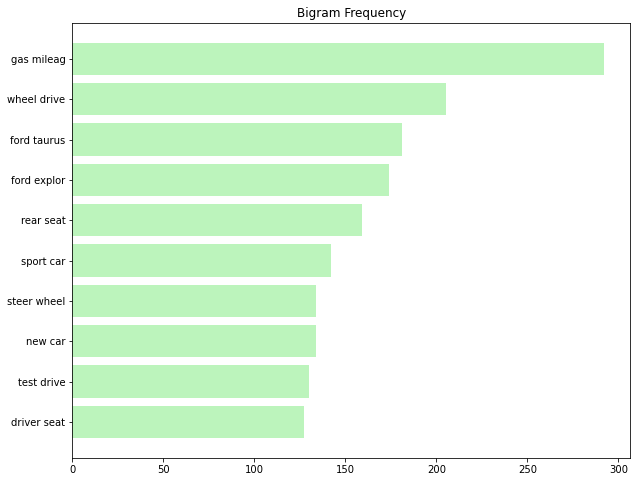

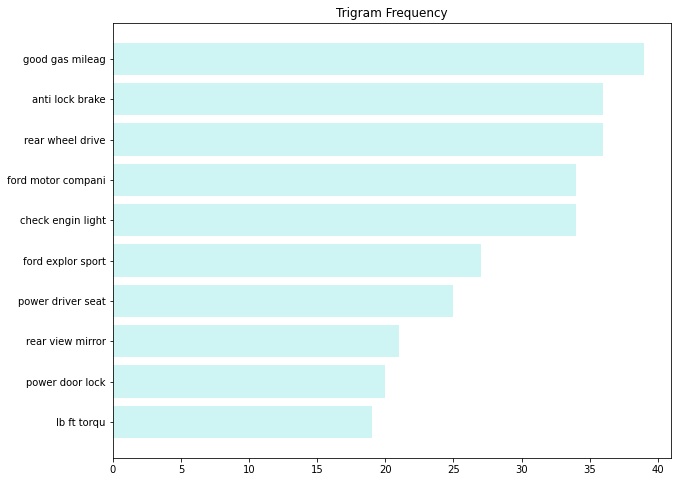

In [21]:
# Create vectorizers using bigrams and trigrams
x_train_stem = stem_docs(x_train)
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), max_features=100)
vectorizer_bigram.fit(x_train_stem)
x_train_bigram = vectorizer_bigram.transform(x_train_stem).toarray()

vectorizer_trigram = CountVectorizer(ngram_range=(3, 3), max_features=100)
vectorizer_trigram.fit(x_train_stem)
x_train_trigram = vectorizer_trigram.transform(x_train_stem).toarray()

# Plot bigram and trigram frequencies
plot_word_freq(x_train_bigram, vectorizer_bigram.get_feature_names(), n_words=10, 
               title='Bigram Frequency', color='lightgreen')
plot_word_freq(x_train_trigram, vectorizer_trigram.get_feature_names(), n_words=10, 
               title='Trigram Frequency', color='paleturquoise')

For bigrams 'gas mileag', 'wheel drive' and 'ford taurus' are the top 3 most frequent terms.
For trigrams 'good gas mileag', 'anti lock brake' and 'rear wheel drive' are the top 3 most frequent terms.

Both bigrams and trigrams are much less frequent than what we have seen for unigrams.

Interestingly, the term 'ford' appears multiple times across the most frequent bigrams and trigrams, which reinforces our earlier hypothesis that the car reviews in our data may be for Ford motorcars exclusively.

#### Testing model configurations
To find which combinations perform the best we will test a total of 32 model configurations using MNB and SVM algorithms and Monte Carlo cv.

For configurations that use a mix of unigrams, bigrams and trigrams we enforce the minimum document frequency to be at least two in order to limit dimensionality.

The specific model configurations we will test are:

| Config. |Algorithm | Stemming/Lemmatization | Bag of words method | N-gram range | Min document frequency 
| :--- | :--- | :--- | :--- | :---: | :---: 
|1|MNB|Stemming|CountVectorizer|(1, 1)|1
|2|MNB|Lemmatization|CountVectorizer|(1, 1)|1
|3|MNB|Stemming|CountVectorizer|(1, 2)|2
|4|MNB|Lemmatization|CountVectorizer|(1, 2)|2
|5|MNB|Stemming|CountVectorizer|(1, 3)|2
|6|MNB|Lemmatization|CountVectorizer|(1, 3)|2
|7|MNB|Stemming|CountVectorizer|(2, 3)|1
|8|MNB|Lemmatization|CountVectorizer|(2, 3)|1
|9|MNB|Stemming|TfidfVectorizer|(1, 1)|1
|10|MNB|Lemmatization|TfidfVectorizer|(1, 1)|1
|11|MNB|Stemming|TfidfVectorizer|(1, 2)|2
|12|MNB|Lemmatization|TfidfVectorizer|(1, 2)|2
|13|MNB|Stemming|TfidfVectorizer|(1, 3)|2
|14|MNB|Lemmatization|TfidfVectorizer|(1, 3)|2
|15|MNB|Stemming|TfidfVectorizer|(2, 3)|1
|16|MNB|Lemmatization|TfidfVectorizer|(2, 3)|1
|17|SVM|Stemming|CountVectorizer|(1, 1)|1
|18|SVM|Lemmatization|CountVectorizer|(1, 1)|1
|19|SVM|Stemming|CountVectorizer|(1, 2)|2
|20|SVM|Lemmatization|CountVectorizer|(1, 2)|2
|21|SVM|Stemming|CountVectorizer|(1, 3)|2
|22|SVM|Lemmatization|CountVectorizer|(1, 3)|2
|23|SVM|Stemming|CountVectorizer|(2, 3)|1
|24|SVM|Lemmatization|CountVectorizer|(2, 3)|1
|25|SVM|Stemming|TfidfVectorizer|(1, 1)|1
|26|SVM|Lemmatization|TfidfVectorizer|(1, 1)|1
|27|SVM|Stemming|TfidfVectorizer|(1, 2)|2
|28|SVM|Lemmatization|TfidfVectorizer|(1, 2)|2
|29|SVM|Stemming|TfidfVectorizer|(1, 3)|2
|30|SVM|Lemmatization|TfidfVectorizer|(1, 3)|2
|31|SVM|Stemming|TfidfVectorizer|(2, 3)|1
|32|SVM|Lemmatization|TfidfVectorizer|(2, 3)|1

In [22]:
# Setting up the parameters - we will trial 16 configurations for both MNB and SVM models
params = 2 * [{'stem':True, 'count_vectorizer':True, 'min_df':1, 'ngram_range':(1, 1)},
              {'stem':False, 'count_vectorizer':True, 'min_df':1, 'ngram_range':(1, 1)},
              {'stem':True, 'count_vectorizer':True, 'min_df':2, 'ngram_range':(1, 2)},
              {'stem':False, 'count_vectorizer':True, 'min_df':2, 'ngram_range':(1, 2)},
              {'stem':True, 'count_vectorizer':True, 'min_df':2, 'ngram_range':(1, 3)},
              {'stem':False, 'count_vectorizer':True, 'min_df':2, 'ngram_range':(1, 3)},
              {'stem':True, 'count_vectorizer':True, 'min_df':1, 'ngram_range':(2, 3)},
              {'stem':False, 'count_vectorizer':True, 'min_df':1, 'ngram_range':(2, 3)},
              {'stem':True, 'count_vectorizer':False, 'min_df':1, 'ngram_range':(1, 1)},
              {'stem':False, 'count_vectorizer':False, 'min_df':1, 'ngram_range':(1, 1)},
              {'stem':True, 'count_vectorizer':False, 'min_df':2, 'ngram_range':(1, 2)},
              {'stem':False, 'count_vectorizer':False, 'min_df':2, 'ngram_range':(1, 2)},
              {'stem':True, 'count_vectorizer':False, 'min_df':2, 'ngram_range':(1, 3)},
              {'stem':False, 'count_vectorizer':False, 'min_df':2, 'ngram_range':(1, 3)},
              {'stem':True, 'count_vectorizer':False, 'min_df':1, 'ngram_range':(2, 3)},
              {'stem':False, 'count_vectorizer':False, 'min_df':1, 'ngram_range':(2, 3)}]

<font color=red> **Warning! The following cell takes approximately 2 hours to run, therefore run_models is set to false to prevent the following cell from running. The cross validation results produced from running the following cell are hardcoded into the following markdown cell.** </font> 

In [23]:
%%time
# Training the models - 16 MNB and 16 SVM
run_models = False
    
if run_models:
    models = [MultinomialNB()] * 16 + [LinearSVC()] * 16
    mccv = MonteCarloCV(models, number_of_runs=30)
    mccv.train_params(x_train, y_train, feature_processing=feature_vectorisation, params=params,
                      verbose=False)
    
    # Creating labels
    model_labels = ['MNB', 'SVM']
    param_labels = ['stemming, count_vec, ngrams:(1,1)',
                    'lemmatize, count_vec, ngrams:(1,1)',
                    'stemming, count_vec, ngrams:(1,2)',
                    'lemmatize, count_vec, ngrams:(1,2)',
                    'stemming, count_vec, ngrams:(1,3)',
                    'lemmatize, count_vec, ngrams:(1,3)',
                    'stemming, count_vec, ngrams:(2,3)',
                    'lemmatize, count_vec, ngrams:(2,3)',
                    'stemming, tdif_vec, ngrams:(1,1)',
                    'lemmatize, tdif_vec, ngrams:(1,1)',
                    'stemming, tdif_vec, ngrams:(1,2)',
                    'lemmatize, tdif_vec, ngrams:(1,2)',
                    'stemming, tdif_vec, ngrams:(1,3)',
                    'lemmatize, tdif_vec, ngrams:(1,3)',
                    'stemming, tdif_vec, ngrams:(2,3)',
                    'lemmatize, tdif_vec, ngrams:(2,3)']
    labels = [ml + ' - ' + pl for ml in model_labels for pl in param_labels]

    # Create a table with results from all the model runs
    results_df = pd.DataFrame()
    results_df['model_configuration'] = labels
    results_df[['mean_accuracy', 'standard_deviation']] = [[v[0], v[1]] for v in mccv.results_dict.values()]
    results_df['sharpe_ratio'] = results_df['mean_accuracy'] / results_df['standard_deviation']
    results_df.sort_values('mean_accuracy', ascending=False)

Wall time: 0 ns


#### Cross validation results

Running the 32 model configurations through cross validation we obtain the following results:

| | model_configuration |	mean_accuracy |	standard_deviation | sharpe_ratio 
| :---: | :-- | :-- | :-- |:-- 
|26|SVM - stemming, tdif_vec, ngrams:(1,2)|0.80261|0.017679|45.39994
|28|SVM - stemming, tdif_vec, ngrams:(1,3)|0.800402|0.018121|44.169086
|24|SVM - stemming, tdif_vec, ngrams:(1,1)|0.798795|0.02067|38.645044
|27|SVM - lemmatize, tdif_vec, ngrams:(1,2)|0.797289|0.019036|41.882422
|29|SVM - lemmatize, tdif_vec, ngrams:(1,3)|0.796888|0.018725|42.558405
|25|SVM - lemmatize, tdif_vec, ngrams:(1,1)|0.791667|0.017872|44.297054
|2|MNB - stemming, count_vec, ngrams:(1,2)|0.778213|0.022113|35.192213
|4|MNB - stemming, count_vec, ngrams:(1,3)|0.77761|0.022901|33.95591
|3|MNB - lemmatize, count_vec, ngrams:(1,2)|0.777309|0.021255|36.570982
|20|SVM - stemming, count_vec, ngrams:(1,3)|0.776104|0.017552|44.218379
|5|MNB - lemmatize, count_vec, ngrams:(1,3)|0.776004|0.022181|34.984313
|18|SVM - stemming, count_vec, ngrams:(1,2)|0.775201|0.016743|46.299987
|10|MNB - stemming, tdif_vec, ngrams:(1,2)|0.774498|0.024231|31.963479
|12|MNB - stemming, tdif_vec, ngrams:(1,3)|0.773193|0.022676|34.097593
|11|MNB - lemmatize, tdif_vec, ngrams:(1,2)|0.77259|0.025614|30.162558
|8|MNB - stemming, tdif_vec, ngrams:(1,1)|0.771787|0.023598|32.705901
|9|MNB - lemmatize, tdif_vec, ngrams:(1,1)|0.770884|0.023805|32.383079
|13|MNB - lemmatize, tdif_vec, ngrams:(1,3)|0.770382|0.024118|31.94284
|1|MNB - lemmatize, count_vec, ngrams:(1,1)|0.769478|0.02098|36.676994
|0|MNB - stemming, count_vec, ngrams:(1,1)|0.767972|0.022627|33.940625
|21|SVM - lemmatize, count_vec, ngrams:(1,3)|0.767671|0.017052|45.02011
|19|SVM - lemmatize, count_vec, ngrams:(1,2)|0.765663|0.016723|45.783845
|17|SVM - lemmatize, count_vec, ngrams:(1,1)|0.755622|0.019454|38.841317
|16|SVM - stemming, count_vec, ngrams:(1,1)|0.754418|0.020572|36.671551
|30|SVM - stemming, tdif_vec, ngrams:(2,3)|0.744378|0.019516|38.141574
|31|SVM - lemmatize, tdif_vec, ngrams:(2,3)|0.743775|0.020309|36.62304
|15|MNB - lemmatize, tdif_vec, ngrams:(2,3)|0.742771|0.021729|34.184122
|14|MNB - stemming, tdif_vec, ngrams:(2,3)|0.742771|0.025518|29.107943
|6|MNB - stemming, count_vec, ngrams:(2,3)|0.741767|0.019033|38.972837
|7|MNB - lemmatize, count_vec, ngrams:(2,3)|0.732731|0.022269|32.903263
|22|SVM - stemming, count_vec, ngrams:(2,3)|0.729217|0.017586|41.464964
|23|SVM - lemmatize, count_vec, ngrams:(2,3)|0.723896|0.017378|41.654733

From the cross-validation results, we can see that models using SVM and TF-IDF vectorization generate the best results. Model configurations which exclude unigrams generate the worst results.

Our best model uses SVM with TF-IDF vectorisation, stemming and both unigrams and bigrams. This model achieves cv accuracy of 80.26% and a standard deviation of 1.77%.

#### Comparing our baseline model with the SVM classifier

Let's run cross validation for the baseline and new classifier and plot the cv density functions

In [24]:
# Compare MNB and SVM models using Monte Carlo Cross Validation
run_mccv = False

if run_mccv:
    models = [MultinomialNB(),
              LinearSVC()]

    params = [{'stem':True, 'count_vectorizer':True, 'min_df':1, 'ngram_range':(1, 1)},
              {'stem':True, 'count_vectorizer':False, 'min_df':2, 'ngram_range':(1, 2)}]

    mccv = MonteCarloCV(models, number_of_runs=30)
    mccv.train_params(x_train, y_train, feature_processing=feature_vectorisation, params=params,
                      verbose=True, verbose_n=10)

    model_labels = ['MNB', 'SVM']
    param_labels = ['stemming, count_vec, ngrams:(1, 1)',
                    'lemmatize, tdif_vec, ngrams:(1, 3)']
    labels = [model_labels[i] + ' ' + param_labels[i] for i in range(len(model_labels))]
    mccv.plot_scores(labels=labels, xlim=(0.67, 0.87))

<img align="left" src='mccv2.png'>

Observing the cv density functions, we can see that the MNB and SVM accuracy distributions are markedly different. The SVM distribution has a higher mean accuracy and a tighter distribution, as measured by the standard deviation. Overall the SVM looks like a better model.

Now let's check performance on the test set:

In [25]:
# Train the model and print accuracy
x_train_lemm = stem_docs(x_train)
x_test_lemm = stem_docs(x_test)

vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2))
vectorizer.fit(x_train_lemm)

x_train_vec = vectorizer.transform(x_train_lemm).toarray()
x_test_vec = vectorizer.transform(x_test_lemm).toarray()
    
clf = LinearSVC()
clf.fit(x_train_vec, y_train)

y_train_pred = clf.predict(x_train_vec)
y_test_pred = clf.predict(x_test_vec)

print_accuracy(y_train, y_train_pred, y_test, y_test_pred)

training set accuracy 1.0
test set accuracy 0.8159


In [26]:
# Print confusion matrices
train_cm_prop = labelled_confusion_matrix(y_train, y_train_pred, prop=True) 
test_cm_prop = labelled_confusion_matrix(y_test, y_test_pred, prop=True) 

print('\ntest set confusion matrix (proportion):')
display(test_cm_prop)


test set confusion matrix (proportion):


,Predicted:0,Predicted:1,Total
Actual:0,0.4007,0.1047,0.5054
Actual:1,0.0794,0.4152,0.4946
Total,0.4801,0.5199,1.0000


The SVM achieves a test set accuracy of 81.59%, a slight improvement over the average cv accuracy of 80.26%.

Looking at the test set confusion matrix we see that 10.47% of our predictions are false positives and 7.94% are false negatives. These represent 15% and 31% respective improvements over our baseline model.

Although we have improved the classifier considerably, it is still a far way from human level performance.

<font color=blue> **Summary**
- After trialling multiple model configurations we find that:
    - Using an SVM and the TF-IDF vectorizer generate superior results compared to using multinomial naive Bayes and a count vectorizer
    - The best model uses SVM with TF-IDF vectorisation, stemming and both unigrams and bigrams. 
    - This model achieves cv accuracy of 80.26%, a 4.5% improvement over the baseline model
    - Our chosen model achieves a test set accuracy of 81.59%, which is consistent with results from cross-validation
    - Although we have managed to improve the results of the classifier, they are still far from human level performance
</font>

### 2.3 Document vectors <a id='part2.3'></a>

So far we have used bag of words models to create numerical representations of the car reviews data. We transform each review into a fixed-length vector, where each element in the vector represents the number of times that a given word appears in the document, or the TF-IDF normalised value if using the TF-IDF vectorizer.

Although they have served us well thus far, bag of words models have several limitations. They suffer from data sparsity and high dimensionality and they ignore the order and semantics of words. For example, 'I live to work' and 'I work to live' have identical bag of words representations, despite the meaning of each sentence being very different due to the differing word order. Additionally, words such as 'run', 'walk' and 'pizza' are equally distant, despite the fact that 'run' and 'walk' are closer semantically.

#### Doc2Vec
Building on the foundations of Word2Vec (Mitkolov et al., 2013), Doc2Vec is an unsupervised learning algorithm which generates densely populated, fixed-length feature representations from documents of varying lengths (Le and Mitkolov, 2014). 

The vector representations are trained to predict the surrounding words in various contexts sampled from the documents. These vector representations are learned via a shallow neural network.

Doc2Vec improves on the shortcomings of bag of words models in several ways: documents can be represented in fewer dimensions, vectors are densely populated and documents with similar meanings share a similar vector space.

#### Training a Doc2Vec model
We will train a Doc2Vec model using Gensim's Doc2Vec implementation and use the following hyperparameter settings as suggested by Lau and Baldwin (2016):
- dm: 0 (use distributed bag of words algorithm instead of distributed memory)
- vector size: 300
- window size: 15
- min count: 5
- sub-sample: 10e-5
- epochs: 20
- alpha: 0.025

#### Sentiment prediction using Doc2Vec
After training a Doc2Vec model, we will transform our reviews into document vectors and use a logistic regression model to predict sentiment.

<font color='orangered'> **Implementation note:**  
A function called feature_vectorisation_d2v is passed into the MonteCarloCV train_params() method and handles the parameters and training of the Doc2Vec model.
    
This function ensures that the document vectors are trained only on the cv training set and then applied to the cv validation set in order to prevent any data leakage.  

See car_reviews_utils.py for further details.
</font>

<font color='red'>**Warning! There are several non-deterministic components in the Doc2Vec model, therefore results in the following cells vary slightly if the cells are run again.** </font>

In [28]:
# Create a logistic regression model using document vectors as features
run_mccv = False

if run_mccv:
    models = [LogisticRegression(max_iter=1000)]

    mccv = MonteCarloCV(models, number_of_runs=30)
    mccv.train(x_train, y_train, feature_processing=feature_vectorisation_d2v, verbose=True, verbose_n=10)

    model_labels = ['Logistic Regression']
    mccv.plot_scores(labels=model_labels, xlim=(0.62, 0.82))

<img align="left" src='mccv3.png'>

The Doc2Vec and logistic regression model achieves a mean cv accuracy of 72.51% with a standard deviation of 2.23%. These results are poor relative to those produced by both MNB and SVM models.

We have used the hyperparameter settings as suggested by Lau and Baldwin (2016), however testing of other hyperparameter combinations could improve performance. This is beyond the scope of this assignment.

Additionally, Doc2Vec models have been shown to perform better when trained on very large corpuses containing millions of examples as well as pretrained word vectors (Lau and Baldwin, 2016). Our corpus is relatively small and this is reflected in the performance of the model.

For completeness, let's check test set performance:

In [29]:
# Train the model and print accuracy
x_train_tagged = label_sentences(x_train, 'Train')
x_test_tagged = label_sentences(x_test, 'Test')

d2v_model = Doc2Vec(dm=0, vector_size=300, window=15, min_count=5, 
                    sample=10e-5, alpha=0.025, epochs=20)
d2v_model.build_vocab(x_train_tagged)
d2v_model.train(x_train_tagged, total_examples=len(x_train_tagged), epochs=d2v_model.epochs)

train_vectors_dbow = get_vectors(d2v_model, x_train_tagged)
test_vectors_dbow = get_vectors(d2v_model, x_test_tagged)
    
clf = LogisticRegression(max_iter=1000)
clf.fit(train_vectors_dbow, y_train)

y_train_pred = clf.predict(train_vectors_dbow)
y_test_pred = clf.predict(test_vectors_dbow)

print_accuracy(y_train, y_train_pred, y_test, y_test_pred)

training set accuracy 0.7837
test set accuracy 0.7329


In [30]:
# Print confusion matrices
test_cm_prop = labelled_confusion_matrix(y_test, y_test_pred, prop=True) 

print('\ntest set confusion matrix (proportion):')
display(test_cm_prop)


test set confusion matrix (proportion):


,Predicted:0,Predicted:1,Total
Actual:0,0.3791,0.1264,0.5054
Actual:1,0.1408,0.3538,0.4946
Total,0.5199,0.4801,1.0000


The Doc2Vec and logistic regression model only achieves an accuracy of 73.29% on the test set.

Observing the test set confusion matrix, we see a 21% increase in false positives and a 77% increase in false negatives compared with our SVM model.

<font color=blue> **Summary**
- Doc2Vec provides an alternative to the bag of words methods we have used so far and enables a more compact representation of our documents and improves on the shortcomings of bag of word models
- We have implemented a Doc2Vec model using hyperparameters suggested by Lau and Baldwin (2016)
- The Doc2Vec and logistic regression model achieves a mean cv accuracy of 72.51% and test set accuracy of 73.29%
- These results are poor relative to the MNB and SVM models
- There is scope to improve these results through further hyperparameter tuning and training on a larger corpus
</font>

### 3. Conclusions <a id='part3'></a>

In this assignment we have explored several methods to predict the sentiment from our car review data. 

In part 1 we cleaned our data, applied stemming, transformed our data using a bag of words model and then used multinomial naive Bayes to predict sentiment.

In part 2 we made efforts to improve our classifier. We have used cross-validation to generate more robust performance estimates and compare models. We have trialled the use of support vector machines, lemmatization, TF-IDF weighting and the inclusion of bigrams and trigrams. We have also touched on the use of more sophisticated representations of our data in the form of document vectors.

Our best model uses a SVM with TF-IDF vectorisation, stemming and both unigrams and bigrams. This model achieves a cv accuracy of 80.26%, a 4.5% improvement over our MNB baseline model. Performance is consistent on the test set, where the SVM achieves 81.59% accuracy. Although we have managed to improve upon our original MNB classifier, the expected performance from our SVM model is still well below human performance.

Results from using Doc2Vec in conjunction with logistic regression are disappointing, however these could be improved through increasing the corpus size and further hyperparameter tuning.

### 4. References <a id='part4'></a>

M. F. Porter. (1980). An algorithm for suffix stripping. Program, 14(3), 130-137. Retrieved from https://tartarus.org/martin/PorterStemmer/def.txt

Snowballstem. (2002). The English (Porter2) stemming algorithm. https://snowballstem.org/algorithms/english/stemmer.html

Wang, S. & Manning, C. D. (2012). Baselines and bigrams: Simple, good sentiment and text classification. In Proceedings of the 50th Annual Meeting of the Association for Computational Linguistics. Retrieved from https://www.aclweb.org/anthology/P12-2018.pdf

Mikolov, T., Chen, K., Corrado, G. & Dean J. (2013). Efficient Estimation of Word Representations in Vector Space. Google. Retrieved from https://arxiv.org/pdf/1301.3781.pdf

Le, Q. & Mikolov, T. (2014). Distributed Representations of Sentences and Documents. In Proceedings of the 31st International Conference on Machine Learning, Beijing, China. Retrieved from https://arxiv.org/pdf/1405.4053.pdf

Zheng, A. (2015). Evaluating Machine Learning Models. Boston, O'Reilly Media.

Lau, J. H. & Balwin, T. (2016). An Empirical Evaluation of doc2vec with Practical Insights into Document Embedding Generation. In Proceedings of the 1st Workshop on Representation Learning for NLP, 78–86. Retrieved from https://www.aclweb.org/anthology/W16-1609.pdf

Geron, A. (2017). Hands-On Machine Learning with Scikit-Learn & TensorFlow. Boston, O'Reilly Media.

Albon, C. (2018). Python Machine Learning Cookbook. Boston, O'Reilly Media.
